<a href="https://colab.research.google.com/github/kornellewy/12-Dimensionality-Reduction-Techniques/blob/master/12_Dimensionality_Reduction_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# get data 
from google.colab import files
uploaded = files.upload()

Saving Test_u94Q5KV.csv to Test_u94Q5KV (1).csv
Saving Train_UWu5bXk.csv to Train_UWu5bXk (1).csv


# 3.1 Missing Value Ratio

In [0]:
train = pd.read_csv("Train_UWu5bXk.csv")

In [4]:
# nuls ?
train.isnull().sum()/len(train)*100 # bo %

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [5]:
nuls = train.isnull().sum()/len(train)*100
vars = train.columns
var = []
for i in range(0,12):
    if (nuls[i]<=20):
        var.append(vars[i])
var

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales']

So the variables to be used are stored in “variable”, which contains only those features where the missing values are less than 20%.

# 3.2 Low Variance Filter

Let’s first impute the missing values in the Item_Weight column using the median value of the known Item_Weight observations

In [0]:
train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True)
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)

In [7]:
train.isnull().sum()/len(train)*100

Item_Identifier              0.0
Item_Weight                  0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Size                  0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64

calculate all varible variance :

In [8]:
train.var()

Item_Weight                  1.786956e+01
Item_Visibility              2.662335e-03
Item_MRP                     3.878184e+03
Outlet_Establishment_Year    7.008637e+01
Item_Outlet_Sales            2.912141e+06
dtype: float64

As the above output shows, the variance of Item_Visibility is very less as compared to the other variables.

In [9]:
# get numeric columns
num = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = train.select_dtypes(include=num)
var = numeric.var()
numeric = numeric.columns
vars = []
for i in range(0, len(var)):
    if (var[i] >= 10):
        vars.append(numeric[i])
vars

['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']

# 3.3 High Correlation filter

High correlation between two variables means they have similar trends and are likely to carry similar information. This can bring down the performance of some models drastically (linear and logistic regression models, for instance). We can calculate the correlation between independent numerical variables that are numerical in nature. If the correlation coefficient crosses a certain threshold value, we can drop one of the variables (dropping a variable is highly subjective and should always be done keeping the domain in mind).

In [10]:
train.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014168,0.024951,0.007739,0.009693
Item_Visibility,-0.014168,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.024951,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,0.007739,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.009693,-0.128625,0.567574,-0.049135,1.000000


**As a general guideline, we should keep those variables which show a decent or high correlation with the target variable.**

Wonderful, we don’t have any variables with a high correlation in our dataset. Generally, if the correlation between a pair of variables is greater than 0.5-0.6, we should seriously consider dropping one of those variables.

# 3.4 Random Forest

Random Forest is one of the most widely used algorithms for feature selection. It comes packaged with in-built feature importance so you don’t need to program that separately. This helps us select a smaller subset of features.

We need to convert the data into numeric form by applying one hot encoding, as Random Forest (Scikit-Learn Implementation) takes only numeric inputs. Let’s also drop the ID variables (Item_Identifier and Outlet_Identifier) as these are just unique numbers and hold no significant importance for us currently.

In [11]:
from sklearn.ensemble import RandomForestRegressor
df=train.drop('Item_Outlet_Sales', 1)
df = df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
model = RandomForestRegressor(random_state=1, max_depth=10)
# one hot encoding
df = pd.get_dummies(df)
model.fit(df, train.Item_Outlet_Sales)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

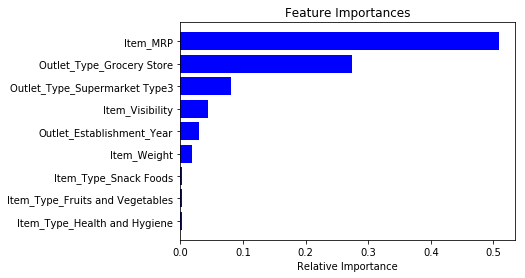

In [12]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Based on the above graph, we can hand pick the top-most features to reduce the dimensionality in our dataset. Alernatively, we can use the SelectFromModel of sklearn to do so. It selects the features based on the importance of their weights.

In [0]:
from sklearn.feature_selection import SelectFromModel
feature = SelectFromModel(model)
fit = feature.fit_transform(df, train.Item_Outlet_Sales)

# 3.5 Backward Feature Elimination


    -We first take all the n variables present in our dataset and train the model using them
    -We then calculate the performance of the model
    -Now, we compute the performance of the model after eliminating each variable (n times), i.e., we drop one variable every time and train the model on the remaining n-1 variables
    -We identify the variable whose removal has produced the smallest (or no) change in the performance of the model, and then drop that variable
    -Repeat this process until no variable can be dropped


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import datasets

In [15]:
lreg = LinearRegression()
rfe = RFE(lreg, 10)
rfe = rfe.fit_transform(df, train.Item_Outlet_Sales)
rfe

array([[0.0160473 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.01927822, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01676007, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.03518627, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.14522065, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04487828, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

# 3.6 Forward Feature Selection


    -We start with a single feature. Essentially, we train the model n number of times using each feature separately
    -The variable giving the best performance is selected as the starting variable
    -Then we repeat this process and add one variable at a time. The variable that produces the highest increase in performance is retained
    -We repeat this process until no significant improvement is seen in the model’s performance


In [16]:
from sklearn.feature_selection import f_regression
ffs = f_regression(df,train.Item_Outlet_Sales )
ffs

(array([8.00638865e-01, 1.43345451e+02, 4.04945623e+03, 2.06215699e+01,
        1.30806126e+00, 1.22585958e+00, 4.36138028e+00, 3.41026049e-01,
        1.95567521e+00, 1.25710921e+01, 4.63353942e-02, 1.84715461e-01,
        4.64996489e-01, 6.68692267e-01, 7.66102777e-01, 5.74173896e+00,
        1.33379794e-01, 5.58240389e+00, 2.10122944e+00, 7.64508603e-02,
        3.85572723e+00, 4.64101498e-01, 4.42472434e+00, 4.92726368e+00,
        1.92759704e+00, 4.98080532e+00, 4.84013114e+01, 8.33163800e+01,
        1.06854461e+02, 2.90220724e+01, 1.83660511e+01, 1.73932135e+03,
        1.02009171e+02, 1.23601667e+01, 9.13656782e+02]),
 array([3.70927701e-001, 9.04128718e-033, 0.00000000e+000, 5.67308211e-006,
        2.52778104e-001, 2.68245018e-001, 3.67921182e-002, 5.59253023e-001,
        1.62012996e-001, 3.93861711e-004, 8.29572434e-001, 6.67362647e-001,
        4.95316603e-001, 4.13530779e-001, 3.81450067e-001, 1.65878107e-002,
        7.14962237e-001, 1.81641436e-002, 1.47217554e-001, 7.8

This returns an array containing the F-values of the variables and the p-values corresponding to each F value. For our purpose, we will select the variables having F-value greater than 1

In [0]:
variable = [ ]
for i in range(0,len(df.columns)-1):
    if ffs[0][i] >=10:
       variable.append(df.columns[i])

**NOTE : Both Backward Feature Elimination and Forward Feature Selection are time consuming and computationally expensive.They are practically only used on datasets that have a small number of input variables.**

# 3.7 Factor Analysis

Suppose we have two variables: Income and Education. These variables will potentially have a high correlation as people with a higher education level tend to have significantly higher income, and vice versa.

In the Factor Analysis technique, variables are grouped by their correlations, i.e., all variables in a particular group will have a high correlation among themselves, but a low correlation with variables of other group(s). Here, each group is known as a factor. These factors are small in number as compared to the original dimensions of the data. However, these factors are difficult to observe.

In [18]:
import pandas as pd
import numpy as np
from glob import glob
import cv2
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [19]:
x_train.shape

(60000, 28, 28)

In [0]:
image = []
for i in range(0,60000):
    img = x_train[i].flatten()
    image.append(img)
x_train = np.array(image)

In [21]:
x_train.shape

(60000, 784)

In [22]:
y_train.shape

(60000,)

In [0]:
feat_cols = [ 'pixel'+str(i) for i in range(x_train.shape[1]) ]
df = pd.DataFrame(x_train, columns=feat_cols)
df['label'] = y_train

In [0]:
from sklearn.decomposition import FactorAnalysis
FA = FactorAnalysis(n_components = 3).fit_transform(df[feat_cols].values)

Here, n_components will decide the number of factors in the transformed data. After transforming the data, it’s time to visualize

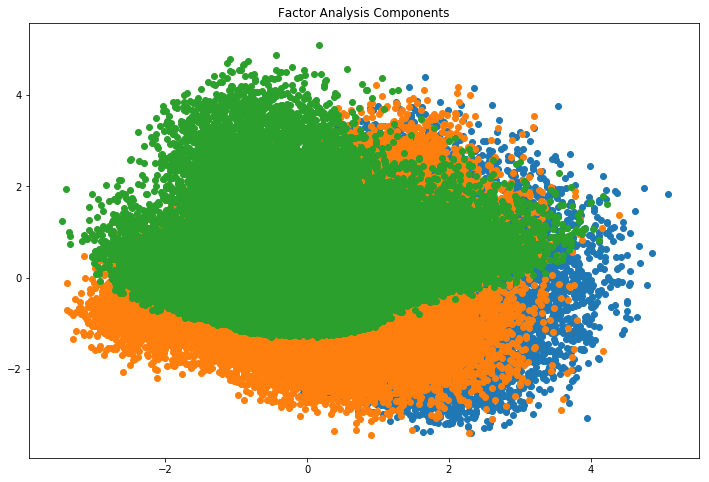

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('Factor Analysis Components')
plt.scatter(FA[:,0], FA[:,1])
plt.scatter(FA[:,1], FA[:,2])
plt.scatter(FA[:,2],FA[:,0])

# 3.8 Principal Component Analysis (PCA)

PCA is a technique which helps us in extracting a new set of variables from an existing large set of variables. These newly extracted variables are called Principal Components.

    -A principal component is a linear combination of the original variables
    -Principal components are extracted in such a way that the first principal component explains maximum variance in the dataset
    -Second principal component tries to explain the remaining variance in the dataset and is uncorrelated to the first principal component
    -Third principal component tries to explain the variance which is not explained by the first two principal components and so on


<Figure size 432x288 with 0 Axes>

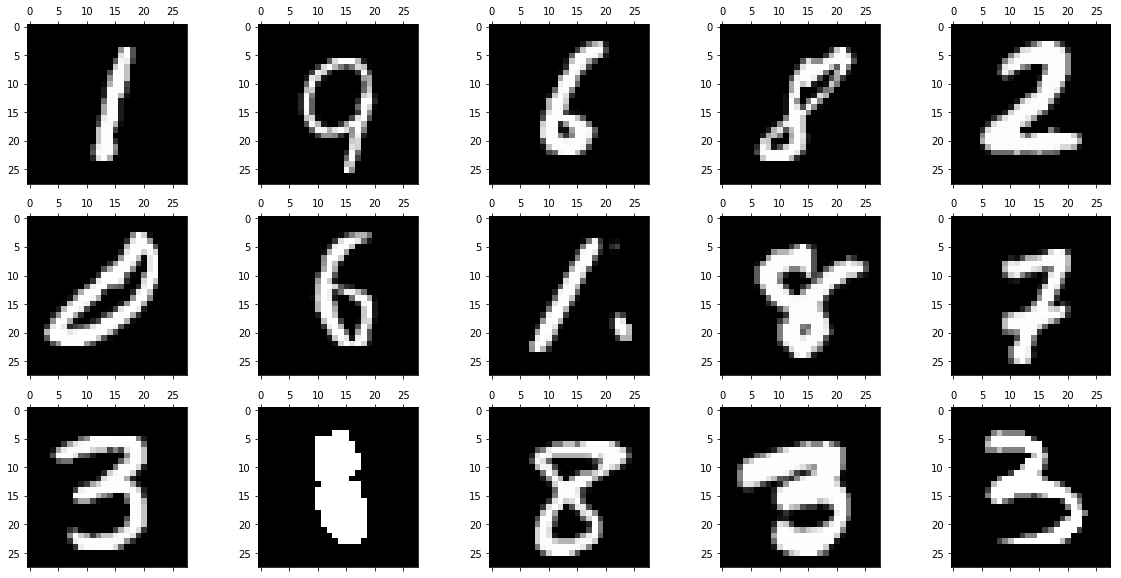

In [27]:
rndperm = np.random.permutation(df.shape[0])
plt.gray()
fig = plt.figure(figsize=(20,10))
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(df[feat_cols].values)

In this case, n_components will decide the number of principal components in the transformed data. Let’s visualize how much variance has been explained using these 10 components.

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

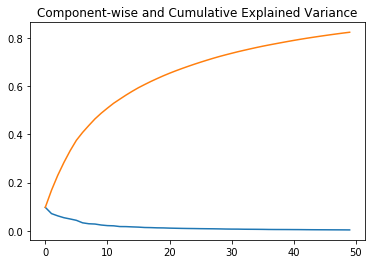

In [37]:
plt.plot(range(50), pca.explained_variance_ratio_)
plt.plot(range(50), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In the above graph, the blue line represents component-wise explained variance while the orange line represents the cumulative explained variance. We are able to explain around 80% variance in the dataset using just 50 components.

Each additional dimension we add to the PCA technique captures less and less of the variance in the model. The first component is the most important one, followed by the second, then the third, and so on.

**SDV** 

We can also use Singular Value Decomposition (SVD) to decompose our original dataset into its constituents, resulting in dimensionality reduction.
SVD decomposes the original variables into three constituent matrices. It is essentially used to remove redundant features from the dataset. It uses the concept of Eigenvalues and Eigenvectors to determine those three matrices. 

In [0]:
from sklearn.decomposition import TruncatedSVD 
svd = TruncatedSVD(n_components=3,
                   random_state=42).fit_transform(df[feat_cols].values)

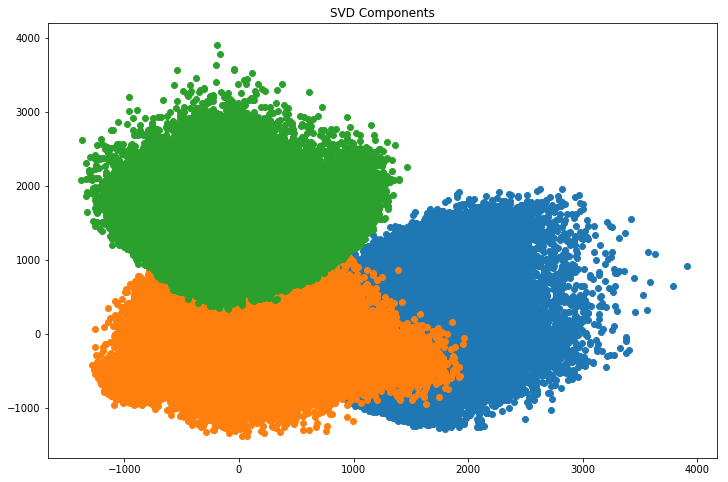

In [39]:
plt.figure(figsize=(12,8))
plt.title('SVD Components')
plt.scatter(svd[:,0], svd[:,1])
plt.scatter(svd[:,1], svd[:,2])
plt.scatter(svd[:,2],svd[:,0])

The above scatter plot shows us the decomposed components very neatly. As described earlier, there is not much correlation between these components.

# 3.9 Independent Component Analysis

Independent Component Analysis (ICA) is based on information-theory and is also one of the most widely used dimensionality reduction techniques. The major difference between PCA and ICA is that PCA looks for uncorrelated factors while ICA looks for independent factors.

If two variables are uncorrelated, it means there is no linear relation between them. If they are independent, it means they are not dependent on other variables. For example, the age of a person is independent of what that person eats, or how much television he/she watches.

This algorithm assumes that the given variables are linear mixtures of some unknown latent variables. It also assumes that these latent variables are mutually independent, i.e., they are not dependent on other variables and hence they are called the independent components of the observed data.

In [0]:
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=3, random_state=12) 
X=ICA.fit_transform(df[feat_cols].values)

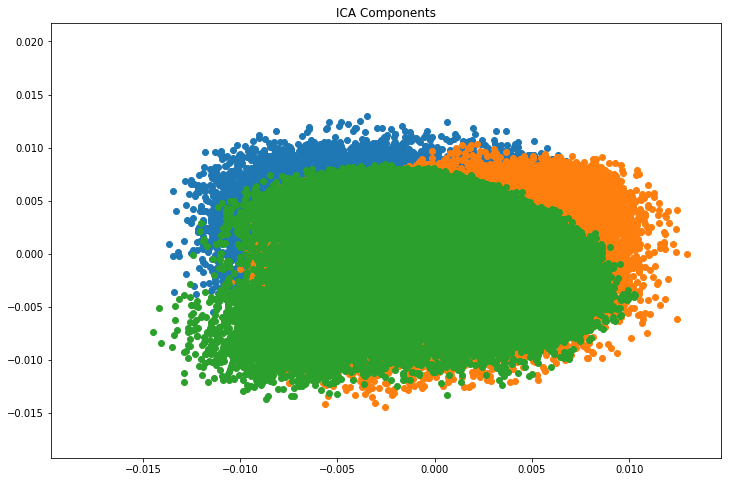

In [41]:
plt.figure(figsize=(12,8))
plt.title('ICA Components')
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[:,1], X[:,2])
plt.scatter(X[:,2], X[:,0])

The data has been separated into different independent components which can be seen very clearly in the above image. X-axis and Y-axis represent the value of decomposed independent components.

# 3.10 Methods Based on Projections

In projection techniques, multi-dimensional data is represented by projecting its points onto a lower-dimensional space.

We will perform non-linear dimensionality reduction through Isometric Mapping. For visualization, we will only take a subset of our dataset as running it on the entire dataset will require a lot of time.

In [0]:
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5,
                             n_components=3,
                             n_jobs=-1).fit_transform(df[feat_cols][:6000].values)


    n_neighbors decides the number of neighbors for each point
    n_components decides the number of coordinates for manifold
    n_jobs = -1 will use all the CPU cores available


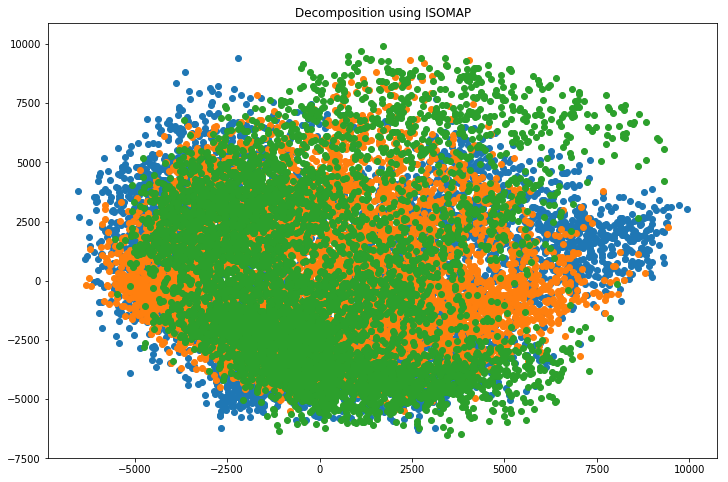

In [43]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using ISOMAP')
plt.scatter(trans_data[:,0], trans_data[:,1])
plt.scatter(trans_data[:,1], trans_data[:,2])
plt.scatter(trans_data[:,2], trans_data[:,0])

# 3.11 t- Distributed Stochastic Neighbor Embedding (t-SNE)

In [0]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=3,
            n_iter=300).fit_transform(df[feat_cols][:6000].values)

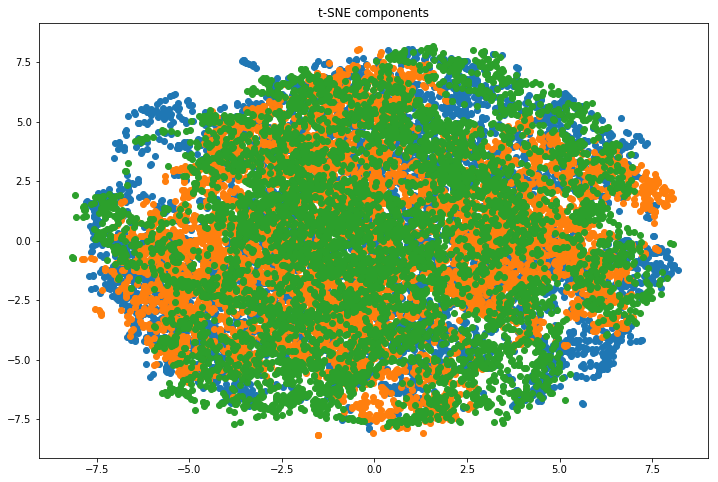

In [45]:
plt.figure(figsize=(12,8))
plt.title('t-SNE components')
plt.scatter(tsne[:,0], tsne[:,1])
plt.scatter(tsne[:,1], tsne[:,2])
plt.scatter(tsne[:,2], tsne[:,0])

# 3.12 UMAP

In [0]:
import umap
umap_data = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      n_components=3).fit_transform(df[feat_cols][:6000].values)

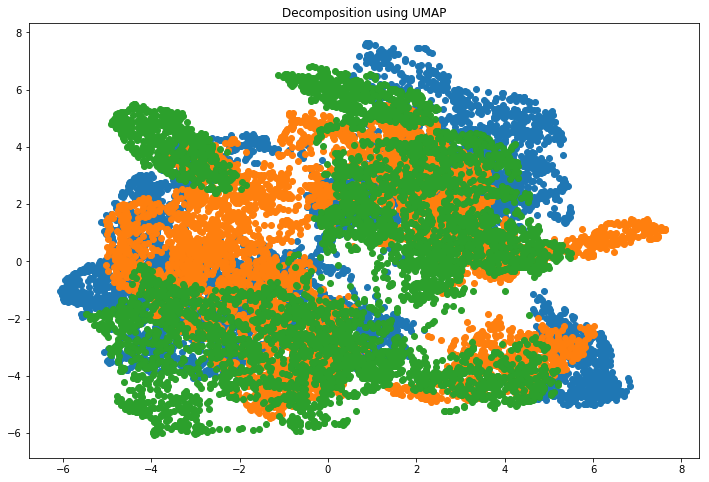

In [48]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using UMAP')
plt.scatter(umap_data[:,0], umap_data[:,1])
plt.scatter(umap_data[:,1], umap_data[:,2])
plt.scatter(umap_data[:,2], umap_data[:,0])

As mentioned in UMAP’s GitHub repository, it often performs better at preserving aspects of the global structure of the data than t-SNE. This means that it can often provide a better “big picture” view of the data as well as preserving local neighbor relations.